**Employee Attrition Analysis using Logistic Regression**

* Step 1 - Correlation Analysis

* Step 2 - Create Logistic Regression Model

* Step 3 - Evaluate the Model

* Step 4 - Calculate feature importance using coefficients

* Step 5 - Optimise the Model

* Step 6 - Evaluate the Model, post optimisation

In [58]:
# Import dependencies
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import password
from passwords import postgres_password

Step 1 - Correlation Analysis:

First, we'll analyze the correlations between features and the target variable (Attrition).

In [59]:
# Establish the connection to postgres database
conn = psycopg2.connect(database = "project_4",
                        user = "postgres",
                        password = postgres_password,
                        host = "localhost",
                        port = "5432"
)

# Import and read the employee_attrition.csv from SQL
attrition_df = pd.read_sql_query('''SELECT * FROM attrition''', conn)

# Close the connection
conn.close()

C:\Users\danie\AppData\Local\Temp\ipykernel_23604\4226612750.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  attrition_df = pd.read_sql_query('''SELECT * FROM attrition''', conn)


In [60]:
# Review dataframe
attrition_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,...,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [61]:
# Drop unnecessary and redundant columns
del attrition_df["employeecount"]
del attrition_df["employeenumber"]
del attrition_df["over18"]
del attrition_df["standardhours"]

attrition_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,...,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [62]:
# Create a custum function to encode binary columns
def encode_column(column):
    if (column == "Yes") | (column == "Male"):
        return 1
    else:
        return 0

In [63]:
# Apply custom function to columns with binary data
attrition_df["attrition"] = attrition_df["attrition"].apply(encode_column)
attrition_df["gender"] = attrition_df["gender"].apply(encode_column)
attrition_df["overtime"] = attrition_df["overtime"].apply(encode_column)
attrition_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,...,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,0,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,1,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,1,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,0,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,...,3,4,1,6,3,3,2,2,2,2


In [64]:
# Encode categorical data to numeric with "pd.get_dummies"
converted_df = pd.get_dummies(attrition_df, columns=["businesstravel", "department", "educationfield", "jobrole", "maritalstatus"], dtype="int")
converted_df.head()

,age,attrition,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,41,1,1102,1,2,2,0,94,3,2,...,0,0,0,0,0,1,0,0,0,1
1,49,0,279,8,1,3,1,61,2,2,...,0,0,0,0,1,0,0,0,1,0
2,37,1,1373,2,2,4,1,92,2,1,...,1,0,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,4,0,56,3,1,...,0,0,0,0,1,0,0,0,1,0
4,27,0,591,2,1,1,1,40,3,1,...,1,0,0,0,0,0,0,0,1,0


attrition                            1.000000
overtime                             0.246118
maritalstatus_Single                 0.175419
jobrole_Sales Representative         0.157234
businesstravel_Travel_Frequently     0.115143
jobrole_Laboratory Technician        0.098290
department_Sales                     0.080855
distancefromhome                     0.077924
educationfield_Technical Degree      0.069355
educationfield_Marketing             0.055781
numcompaniesworked                   0.043494
educationfield_Human Resources       0.036466
jobrole_Human Resources              0.036215
gender                               0.029453
jobrole_Sales Executive              0.019774
department_Human Resources           0.016832
monthlyrate                          0.015170
performancerating                    0.002889
jobrole_Research Scientist          -0.000360
hourlyrate                          -0.006846
percentsalaryhike                   -0.013478
educationfield_Other              

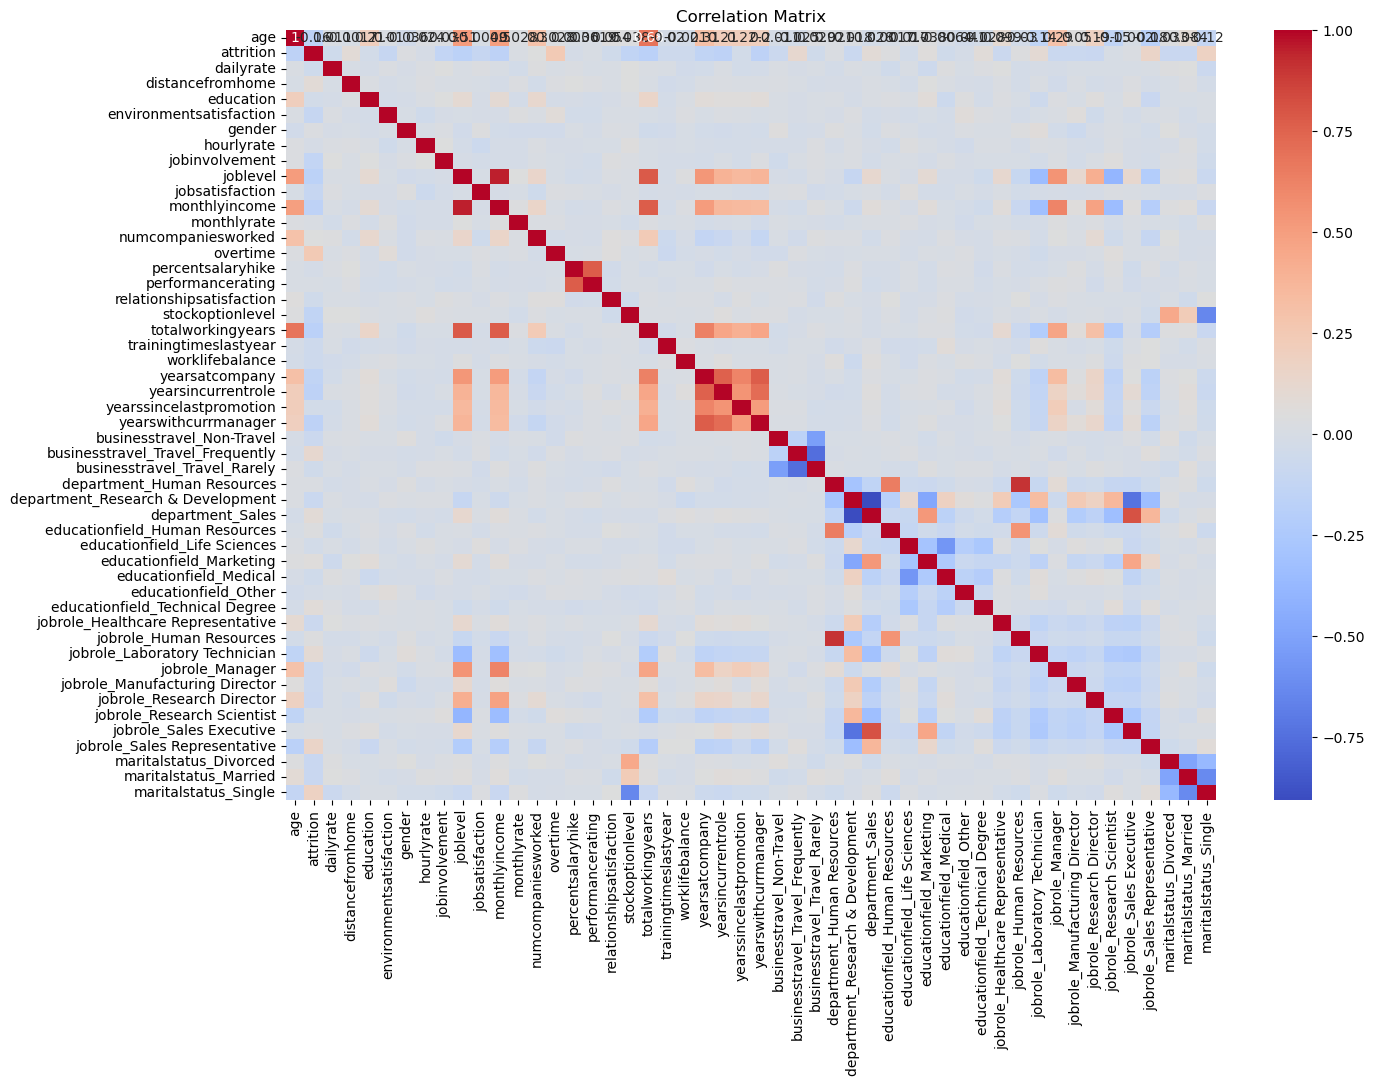

In [65]:
# Compute the correlation matrix
corr_matrix = converted_df.corr()

# Correlation with target variable 'Attrition_Yes'
corr_target = corr_matrix["attrition"].sort_values(ascending=False)
print(corr_target)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.savefig("output/correlation_matrix", bbox_inches = 'tight')
plt.show()


Step 2 - Create a Logistic Regression Model:

In [66]:
# Split our preprocessed data into our features and target arrays
y = converted_df["attrition"]
X = converted_df.drop(columns=["attrition"])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    stratify=y)

In [67]:
# Review targets
pd.DataFrame(y).head()

,attrition
0,1
1,0
2,1
3,0
4,0


In [68]:
# Review features
X.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,41,1102,1,2,2,0,94,3,2,4,...,0,0,0,0,0,1,0,0,0,1
1,49,279,8,1,3,1,61,2,2,2,...,0,0,0,0,1,0,0,0,1,0
2,37,1373,2,2,4,1,92,2,1,3,...,1,0,0,0,0,0,0,0,0,1
3,33,1392,3,4,4,0,56,3,1,3,...,0,0,0,0,1,0,0,0,1,0
4,27,591,2,1,1,1,40,3,1,2,...,1,0,0,0,0,0,0,0,1,0


In [69]:
# Create logistic regerssion model
model = LogisticRegression(solver="lbfgs",
                                max_iter=200,
                                random_state=1)
model

LogisticRegression(max_iter=200, random_state=1)

In [70]:
# Fit training data to model
model.fit(X_train, y_train)

c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, random_state=1)

In [71]:
# Make predictions on testing data
predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


Step 3 - Evaluate the Model:

In [72]:
# Display the accuracy score for the test dataset.
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, predictions)}")

Logistic Regression Accuracy: 0.8288043478260869


In [73]:
# Print the classification report for the model
target_names = ["Attrition", "No Attrition"]
print(classification_report(y_test, predictions, target_names = target_names))

              precision    recall  f1-score   support

   Attrition       0.84      0.98      0.91       309
No Attrition       0.17      0.02      0.03        59

    accuracy                           0.83       368
   macro avg       0.50      0.50      0.47       368
weighted avg       0.73      0.83      0.77       368



In [74]:
# Generate the confusion matrix for the model
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix


array([[304,   5],
       [ 58,   1]], dtype=int64)

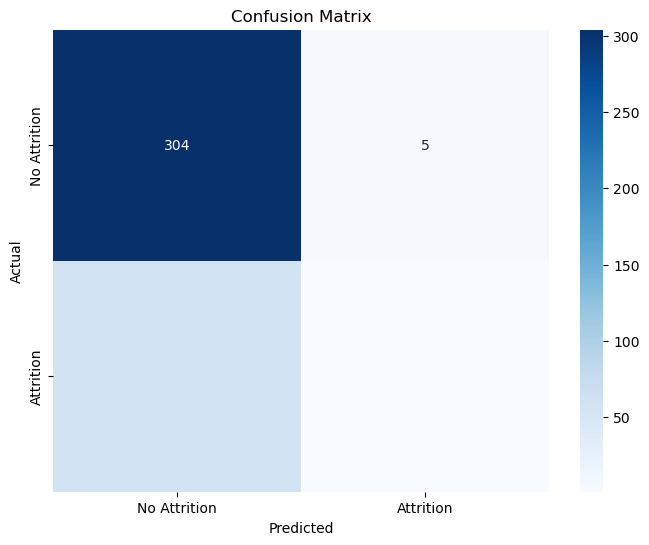

In [75]:
# Visualise the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Attrition", "Attrition"], yticklabels=["No Attrition", "Attrition"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("output/confusion_matrix", bbox_inches = 'tight')
plt.show()

Step 4 - Calculate feature importance using coefficients:

In [76]:
# Calculate model coefficients, for feature importance
coefs = model.coef_[0]
coefs

array([-2.21538294e-02, -5.38730581e-05,  4.15071386e-02,  3.17510373e-02,
       -1.52725686e-01,  3.39709594e-02,  7.75157482e-03, -1.04767414e-01,
       -8.15860814e-03, -1.45000774e-01, -1.67261396e-04,  2.35462649e-05,
        1.84937130e-01,  1.13995389e-01, -6.74358562e-03,  8.16217296e-03,
       -4.21022766e-02, -1.32404411e-01,  1.08257832e-02, -9.42564795e-02,
       -6.71596701e-02,  8.14364776e-02, -1.28836168e-01,  1.55389439e-01,
       -1.40838719e-01, -2.62558796e-02,  4.57010338e-02, -1.70672020e-02,
        1.18840832e-02, -5.27475638e-02,  4.32414328e-02,  9.63899564e-03,
       -3.68925673e-02,  2.44374952e-02, -1.89552799e-02, -7.03976202e-03,
        3.11890706e-02, -1.49066108e-02,  1.30182075e-02,  2.09988388e-02,
       -1.85415452e-03, -1.67036741e-02, -6.40599938e-03, -3.31518002e-02,
        1.43080989e-02,  2.70750460e-02, -4.83591227e-02, -3.41665024e-02,
        8.49035774e-02])

In [77]:
# Create feature importance dataframe
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefs)}).sort_values('Importance', ascending=False).reset_index(drop=True)
feature_importance_df.head()

,Feature,Importance
0,numcompaniesworked,0.184937
1,yearssincelastpromotion,0.155389
2,environmentsatisfaction,0.152726
3,jobsatisfaction,0.145001
4,yearswithcurrmanager,0.140839


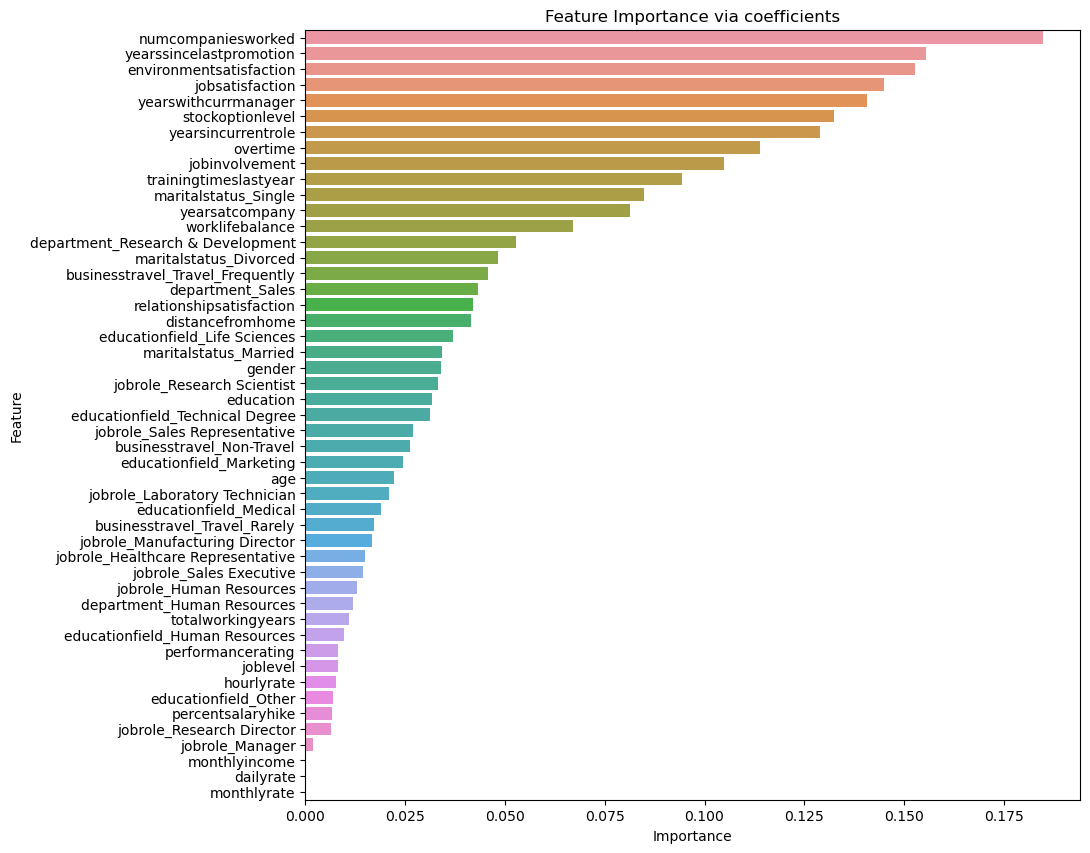

In [87]:
# Plot feature importance
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance via coefficients')
plt.savefig("output/feature_importance_coefficients", bbox_inches = 'tight')
plt.show()


Step 5 - Optimise the Model:

In [79]:
# Drop the 5 least important features
X = X.drop(columns = ["monthlyrate", "dailyrate", "monthlyincome", "percentsalaryhike", "hourlyrate"])

X.head()

,age,distancefromhome,education,environmentsatisfaction,gender,jobinvolvement,joblevel,jobsatisfaction,numcompaniesworked,overtime,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,41,1,2,2,0,3,2,4,8,1,...,0,0,0,0,0,1,0,0,0,1
1,49,8,1,3,1,2,2,2,1,0,...,0,0,0,0,1,0,0,0,1,0
2,37,2,2,4,1,2,1,3,6,1,...,1,0,0,0,0,0,0,0,0,1
3,33,3,4,4,0,3,1,3,1,1,...,0,0,0,0,1,0,0,0,1,0
4,27,2,1,1,1,3,1,2,9,0,...,1,0,0,0,0,0,0,0,1,0


In [80]:
# Re-split the newly preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    stratify=y)

In [81]:
# Re-fit the training data to the model
model.fit(X_train, y_train)

c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, random_state=1)

In [82]:
# Make predictions on testing data
predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,0,0
2,1,0
3,1,0
4,0,0


Step 6 - Evaluate the Model, post optimisation:

In [83]:
# Display the accuracy score for the test dataset.
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, predictions)}")

Logistic Regression Accuracy: 0.875


In [84]:
# Print the classification report for the optimised model
target_names = ["Attrition", "No Attrition"]
print(classification_report(y_test, predictions, target_names = target_names))

              precision    recall  f1-score   support

   Attrition       0.90      0.95      0.93       309
No Attrition       0.65      0.47      0.55        59

    accuracy                           0.88       368
   macro avg       0.78      0.71      0.74       368
weighted avg       0.86      0.88      0.87       368



In [85]:
# Generate the confusion matrix for the optimised model
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix

array([[294,  15],
       [ 31,  28]], dtype=int64)

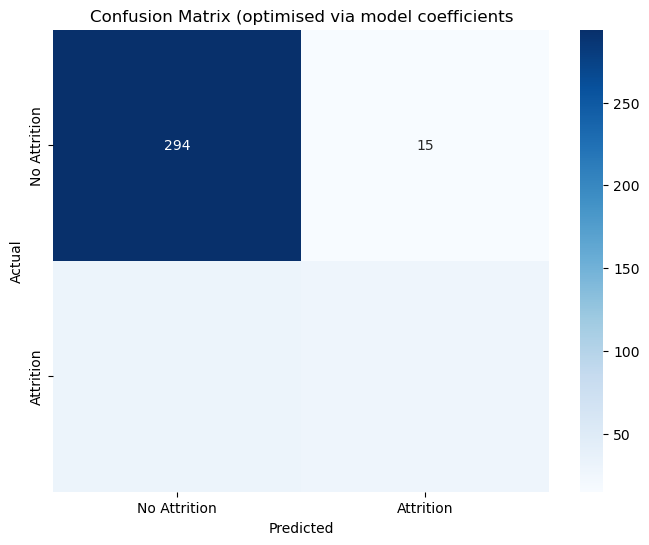

In [86]:
# Visualise the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Attrition", "Attrition"], yticklabels=["No Attrition", "Attrition"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (optimised via model coefficients)")
plt.savefig("output/confusion_matrix_optimisation_coefficients", bbox_inches = 'tight')
plt.show()